In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import datetime as dt
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman
import datetime as dt
from linearmodels.iv import IV2SLS
from itertools import combinations

%matplotlib inline

## Import Data

In [2]:
price_df       = pd.read_csv('../data/electricity/elc_retail_price_monthly.csv', na_values = 'NM')
sales_df       = pd.read_csv('../data/electricity/elc_retail_sales_monthly.csv', na_values = 'NM')
fossil_cost_df = pd.read_csv('../data/fossil/avg_cost_fossil.csv', na_values = ['W', '--', 'NM'])
pcepi_df       = pd.read_csv('../data/inflation/us_pcepi.csv')
ddd_df         = pd.read_csv('../data/temperature/state_monthly_hdd_cdd.csv')

## Clean Data

In [3]:
# Fix state names
sales_df['State']       = sales_df['State'].apply(lambda x: x.strip().lower()) 
price_df['State']       = price_df['State'].apply(lambda x: x.strip().lower()) 
fossil_cost_df['state'] = fossil_cost_df['state'].apply(lambda x: x.strip().lower()) 

# Fix dates
pcepi_df['month'] = pcepi_df['DATE'].apply(lambda x: x.split('/')[0])
pcepi_df['year']  = pcepi_df['DATE'].apply(lambda x: x[-4:])
ddd_df['month']   = ddd_df['month'].astype(str)
ddd_df['year']    = ddd_df['year'].astype(str)


# Reshape dataframes
sales_melt_df  = pd.melt(sales_df, id_vars = ['State'], value_vars = sales_df.columns[1:],
       var_name = 'date', value_name = 'load')


price_melt_df  = pd.melt(price_df, id_vars = ['State'], value_vars = price_df.columns[1:],
       var_name = 'date', value_name = 'price')


fossil_cost_df = pd.melt(fossil_cost_df, id_vars = ['state', 'fuel'], value_vars = fossil_cost_df.columns[4:],
       var_name = 'date', value_name = 'cost').reset_index(drop = True)
fossil_cost_df['cost'] = fossil_cost_df['cost'].fillna(-1234)
fossil_cost_df = fossil_cost_df.groupby(['state', 'date', 'fuel'])['cost'].sum().unstack('fuel').reset_index()
fossil_cost_df.columns = (list(fossil_cost_df.columns[:2]) + 
                          [x.strip().replace(' ', '_') + '_cost' for x in fossil_cost_df.columns[2:]])

In [4]:
data_df = price_melt_df.merge(sales_melt_df, on = ['State', 'date']).rename(columns = {'State': 'state'}).merge(
            fossil_cost_df, on = ['state', 'date'])

# Month abbreviations
month_abrv_dict = dict(zip(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                          range(1,13)))

# Clean up columns
data_df['state'] = data_df['state'].apply(lambda x: x.strip().lower()) 
data_df['month'] = data_df['date'].apply(lambda x: str(month_abrv_dict.get(x.split('-')[0])))
data_df['year']  = data_df['date'].apply(lambda x: str(2000+int(x.split('-')[1])))
data_df['price'] = pd.to_numeric(data_df['price'])/100
data_df['load']  = pd.to_numeric(data_df['load'])

# Merge with pcepi and ddd data
data_df = data_df.merge(pcepi_df, on =['month', 'year']).drop('DATE', axis = 1).merge(
                        ddd_df, on = ['state', 'month', 'year'])

# Fix entries in fuel cost
fuel_cost_cols = [x for x in data_df.columns if 'cost' in x]
for fuel_cost_col in fuel_cost_cols:
    data_df[fuel_cost_col] = pd.to_numeric(fossil_cost_df[fuel_cost_col]).apply(
        lambda x: np.nan if (x == -1234 or x == 0) else x)
    
# Adjust for inflation
for price_col in (fuel_cost_cols + ['price']):
    data_df[price_col] = data_df[price_col]*100/data_df['PCEPI']
    
# Fix date columns
data_df['month'] = data_df['month'].astype(int) 
data_df['year']  = data_df['year'].astype(int)  

In [5]:
data_df.head()

,state,date,price,load,coal_cost,natural_gas_cost,petroleum_coke_cost,petroleum_liquids_cost,month,year,PCEPI,CDD,HDD
0,connecticut,Dec-10,0.193249,1187.0,NaN,NaN,NaN,NaN,12,2010,96.456,0.0,118.0
1,maine,Dec-10,0.163391,431.0,NaN,NaN,NaN,NaN,12,2010,96.456,0.0,199.0
2,massachusetts,Dec-10,0.149498,1921.0,NaN,NaN,NaN,NaN,12,2010,96.456,0.0,113.0
3,new hampshire,Dec-10,0.170544,391.0,61.115949,4.903790,NaN,132.858505,12,2010,96.456,0.0,250.0
4,rhode island,Dec-10,0.154993,275.0,NaN,2.322302,NaN,NaN,12,2010,96.456,0.0,76.0


## Data Description

In [7]:
data_df.query('coal_cost == coal_cost')[['price', 'load', 'coal_cost', 'CDD', 'HDD']].describe()

,price,load,coal_cost,CDD,HDD
count,848.000000,848.00000,848.000000,848.000000,848.000000
mean,0.118393,2454.96934,46.004220,64.662736,443.199292
std,0.027906,2380.24399,17.683376,134.965191,412.267006
min,0.076601,144.00000,24.038135,0.000000,0.000000
25%,0.098699,790.50000,33.429777,0.000000,48.000000
50%,0.110991,1869.50000,41.396633,0.000000,367.000000
75%,0.128693,3315.00000,51.831937,47.250000,754.500000
max,0.208995,18621.00000,107.489340,761.000000,1794.000000


## Plots

In [60]:
import datetime as dt

data_df['date_fmt'] = data_df['date'].apply(lambda x: dt.datetime.strptime(x, '%b-%y'))

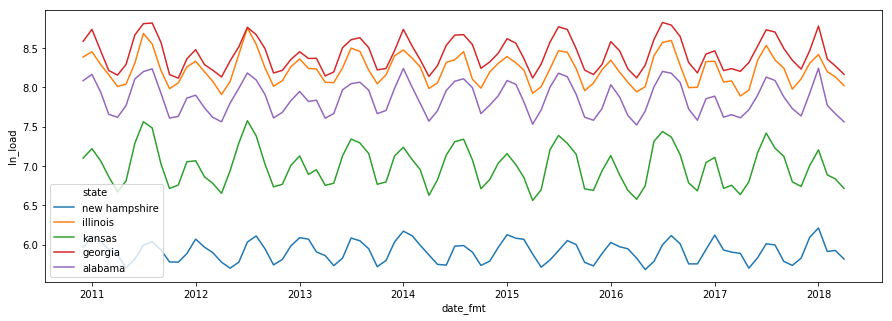

In [68]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,5))

state_sample = data_df.groupby('state').first().sample(5).reset_index()['state'].unique()
data_df['ln_load'] = np.log(data_df['load'])
sns.lineplot(x = 'date_fmt', y = 'ln_load', hue = 'state', data = data_df.query('state in @state_sample'), ax = ax)

## Construct Reg Data

In [74]:
def drop_outliers(df, columns, frac = 0.05):
    
    df = df.copy()
    
    # Mark outliers for each column
    for column in columns:
        cut_low, cut_high = df[column].quantile([frac/2, (1-frac/2)])
        df[column + '_keep'] = ((df[column] < cut_high) & (df[column] > cut_low)).astype(int)
        
    # Subset to observations that aren't outliers for any column
    query_str = ' & '.join([x + '_keep == 1' for x in columns])
    
    return df.query(query_str).drop([x + '_keep' for x in columns], axis = 1).copy()

def df_drop_na(df, cols):
    
    return df[~df[cols].isna().any(axis=1)]

In [174]:
# Subset dataframe for relevant variables
em_sample_df = data_df[['state', 'price', 'load', 'month', 'year', 'coal_cost', 'CDD', 'HDD']].copy()

# Drop missing and outliers (CDD and HDD data already cleaned)
em_sample_df[~em_sample_df.isna().any(axis = 1)]
em_sample_df = drop_outliers(em_sample_df, columns = ['price', 'load', 'coal_cost'], frac = 0.01).reset_index(drop = True)

# Add date column
em_sample_df['date'] = em_sample_df.apply(lambda x: '{0}/{1}'.format(x.month, x.year), axis = 1)

print('Preliminary Data Set Observations:  ', len(em_sample_df))

Preliminary Data Set Observations:   818


In [175]:
# Get all unique combinations of (t,s,i,j)
sample_array = np.array([np.array(comb) for comb in combinations(em_sample_df.index, 2)])

# Split into two dataframes for (t,i) and (s,j)
em_sample_df_1         = em_sample_df.loc[sample_array[:,0]].reset_index(drop = True)
em_sample_df_1.columns = [x + '_1' for x in em_sample_df_1.columns] 
em_sample_df_2         = em_sample_df.loc[sample_array[:,1]].reset_index(drop = True)
em_sample_df_2.columns = [x + '_2' for x in em_sample_df_2.columns] 

In [176]:
# Merge and filter out t == s and i != j
em_concat_df = pd.concat([em_sample_df_1, em_sample_df_2], axis = 1)
em_concat_df = em_concat_df.query('state_1 == state_2 & date_1 != date_2').drop_duplicates().reset_index(drop = True)

In [177]:
# Add reg data columns
em_concat_df['ln_load_rel']    = np.log(np.divide(em_concat_df['load_1'], em_concat_df['load_2']))
em_concat_df['ln_price_rel']   = np.log(np.divide(em_concat_df['price_1'], em_concat_df['price_2']))
em_concat_df['ln_coal_rel']    = np.log(np.divide(em_concat_df['coal_cost_1'], em_concat_df['coal_cost_2']))

# Regressions should be done with pairs of data for the same state
reg_data_df = em_concat_df.copy()
reg_data_df['time_diff'] = (reg_data_df
                            .apply(lambda x: 
                                   dt.datetime(x.year_1, x.month_1, 1) - dt.datetime(x.year_2, x.month_2, 1), 
                                   axis = 1)
                            .apply(lambda x: np.round(x.days/30.4, 0)))

print('Regression Data Set Observations:  ', len(reg_data_df))

Regression Data Set Observations:   6817


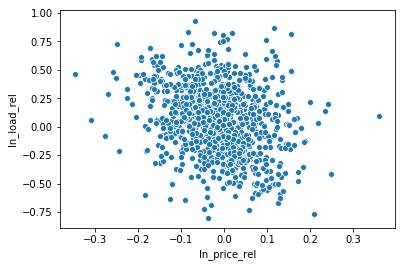

In [178]:
sns.scatterplot(x = 'ln_price_rel', y = 'ln_load_rel', data = reg_data_df.sample(n=1000))

In [179]:
reg_data_df.to_csv('../data/processed/ces_monthly.csv', index = False)

## Estimation

### OLS

In [128]:
smf.ols('ln_load_rel~ ln_price_rel', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     555.8
Date:                Sat, 04 May 2019   Prob (F-statistic):          7.79e-118
Time:                        13:59:56   Log-Likelihood:                -1062.1
No. Observations:                6292   AIC:                             2128.
Df Residuals:                    6290   BIC:                             2142.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0312      0.004      8.524      0.000       0.024       0.038
ln_price_rel    -0.9667      0.041    -23.576      0.000      -1.047      -0.886
==============================================================================
Omnibus:                        8.359   Durbin-Watson:                   0.738
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.370
Skew:                           0.080   Prob(JB):                       0.0152
Kurtosis:                       3.081   Cond. No.                         11.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
smf.ols('ln_load_rel~ ln_price_rel + C(state_1) + C(state_2)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     18.38
Date:                Sat, 04 May 2019   Prob (F-statistic):          9.57e-143
Time:                        13:59:59   Log-Likelihood:                -912.69
No. Observations:                6292   AIC:                             1923.
Df Residuals:                    6243   BIC:                             2254.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0702      0.020      3.501      0.000       0.031       0.109
C(state_1)[T.arizona]        -2.894e+11   1.05e+12     -0.276      0.783   -2.35e+12    1.77e+12
C(state_1)[T.arkansas]        6.161e+09   8.24e+11      0.007      0.994   -1.61e+12    1.62e+12
C(state_1)[T.california]      4.436e+10   1.58e+12      0.028      0.978   -3.06e+12    3.15e+12
C(state_1)[T.colorado]        1.077e+11   8.24e+11      0.131      0.896   -1.51e+12    1.72e+12
C(state_1)[T.connecticut]     1.551e+11   1.04e+12      0.149      0.882   -1.89e+12     2.2e+12
C(state_1)[T.delaware]        -1.41e+12    1.6e+12     -0.884      0.377   -4.54e+12    1.72e+12
C(state_1)[T.florida]          2.28e+11   1.42e+12      0.160      0.873   -2.56e+12    3.02e+12
C(state_1)[T.georgia]         8.224e+11   1.61e+12      0.511      0.609   -2.33e+12    3.98e+12
C(state_1)[T.idaho]          -8.293e+11   1.85e+12     -0.448      0.654   -4.46e+12     2.8e+12
C(state_1)[T.illinois]       -5.594e+11   1.67e+12     -0.335      0.738   -3.83e+12    2.71e+12
C(state_1)[T.indiana]        -4.086e+11   1.11e+12     -0.367      0.714   -2.59e+12    1.77e+12
C(state_1)[T.iowa]            -1.46e+11   1.98e+12     -0.074      0.941   -4.02e+12    3.73e+12
C(state_1)[T.kansas]         -9.105e+10   1.63e+12     -0.056      0.956    -3.3e+12    3.11e+12
C(state_1)[T.kentucky]       -2.459e+11    9.9e+11     -0.249      0.804   -2.19e+12    1.69e+12
C(state_1)[T.louisiana]      -2.141e+11   1.16e+12     -0.185      0.854   -2.49e+12    2.06e+12
C(state_1)[T.maine]          -3.271e+11   1.11e+12     -0.294      0.769   -2.51e+12    1.85e+12
C(state_1)[T.maryland]       -1.026e+11   1.25e+11     -0.818      0.414   -3.48e+11    1.43e+11
C(state_1)[T.massachusetts]  -3.113e+11   1.27e+12     -0.245      0.806    -2.8e+12    2.18e+12
C(state_1)[T.michigan]        1.449e+11   1.56e+11      0.931      0.352    -1.6e+11     4.5e+11
C(state_1)[T.minnesota]      -1.288e+12   1.81e+12     -0.710      0.477   -4.84e+12    2.27e+12
C(state_1)[T.mississippi]    -4.381e+11   1.45e+12     -0.302      0.763   -3.28e+12    2.41e+12
C(state_1)[T.missouri]        8.178e+11    1.7e+12      0.480      0.631   -2.52e+12    4.16e+12
C(state_1)[T.montana]        -7.717e+10   8.27e+10     -0.934      0.351   -2.39e+11    8.49e+10
C(state_1)[T.nebraska]        1.397e+12   2.03e+12      0.690      0.490   -2.57e+12    5.37e+12
C(state_1)[T.nevada]          1.315e+11   1.54e+11      0.855      0.393    -1.7e+11    4.33e+11
C(state_1)[T.new hampshire]  -1.231e+12   1.62e+12     -0.759      0.448   -4.41e+12    1.95e+12
C(state_1)[T.new jersey]     -1.835e+11   6.64e+11     -0.276      0.782   -1.49e+12    1.12e+12
C(state_1)[T.new mexico]      1.676e+12   1.56e+12      1.072      0.284   -

In [130]:
smf.ols('ln_load_rel~ ln_price_rel + C(month_1) + C(month_2)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     398.0
Date:                Sat, 04 May 2019   Prob (F-statistic):               0.00
Time:                        14:00:04   Log-Likelihood:                 1503.9
No. Observations:                6292   AIC:                            -2960.
Df Residuals:                    6268   BIC:                            -2798.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0056      0.010      0.580      0.562      -0.013       0.024
C(month_1)[T.2]     -0.1967      0.009    -21.711      0.000      -0.214      -0.179
C(month_1)[T.3]     -0.2866      0.011    -26.849      0.000      -0.308      -0.266
C(month_1)[T.4]     -0.4546      0.012    -39.022      0.000      -0.477      -0.432
C(month_1)[T.5]     -0.3855      0.012    -31.331      0.000      -0.410      -0.361
C(month_1)[T.6]     -0.1980      0.012    -17.027      0.000      -0.221      -0.175
C(month_1)[T.7]      0.0570      0.012      4.738      0.000       0.033       0.081
C(month_1)[T.8]     -0.0103      0.011     -0.918      0.359      -0.032       0.012
C(month_1)[T.9]     -0.1859      0.011    -16.348      0.000      -0.208      -0.164
C(month_1)[T.10]    -0.4176      0.012    -34.319      0.000      -0.441      -0.394
C(month_1)[T.11]    -0.3488      0.013    -26.072      0.000      -0.375      -0.323
C(month_1)[T.12]    -0.0857      0.010     -8.571      0.000      -0.105      -0.066
C(month_2)[T.2]      0.1713      0.009     18.228      0.000       0.153       0.190
C(month_2)[T.3]      0.2616      0.009     27.770      0.000       0.243       0.280
C(month_2)[T.4]      0.4128      0.010     42.578      0.000       0.394       0.432
C(month_2)[T.5]      0.3985      0.014     27.999      0.000       0.371       0.426
C(month_2)[T.6]      0.1777      0.017     10.691      0.000       0.145       0.210
C(month_2)[T.7]     -0.0546      0.021     -2.644      0.008      -0.095      -0.014
C(month_2)[T.8]      0.0644      0.014      4.591      0.000       0.037       0.092
C(month_2)[T.9]      0.1876      0.012     16.209      0.000       0.165       0.210
C(month_2)[T.10]     0.3881      0.011     34.612      0.000       0.366       0.410
C(month_2)[T.11]     0.3307      0.010     32.633      0.000       0.311       0.351
C(month_2)[T.12]     0.1211      0.010     12.269      0.000       0.102       0.140
ln_price_rel        -0.3971      0.033    -11.998      0.000      -0.462      -0.332
==============================================================================
Omnibus:                      224.288   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.703
Skew:                          -0.117   Prob(JB):                    2.97e-132
Kurtosis:                       4.502   Cond. No.                         16.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [288]:
smf.ols('ln_load_rel~ ln_price_rel + C(state_1) + C(state_2) + C(month_1) + C(month_2)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     167.9
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:08:50   Log-Likelihood:                 1341.3
No. Observations:                9411   AIC:                            -2553.
Df Residuals:                    9346   BIC:                            -2088.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0022      0.017      0.130      0.896      -0.030       0.035
C(state_1)[T.arizona]         1.639e+12   6.35e+11      2.580      0.010    3.94e+11    2.88e+12
C(state_1)[T.arkansas]        2.004e+12   6.89e+11      2.909      0.004    6.54e+11    3.35e+12
C(state_1)[T.california]      -1.36e+10    4.4e+11     -0.031      0.975   -8.75e+11    8.48e+11
C(state_1)[T.colorado]        1.455e+12   7.66e+11      1.900      0.058   -4.64e+10    2.96e+12
C(state_1)[T.connecticut]    -2.918e+11      8e+11     -0.365      0.715   -1.86e+12    1.28e+12
C(state_1)[T.delaware]        6.177e+10   4.16e+11      0.148      0.882   -7.54e+11    8.77e+11
C(state_1)[T.florida]        -2.486e+11   7.18e+11     -0.346      0.729   -1.66e+12    1.16e+12
C(state_1)[T.georgia]        -6.433e+11   4.47e+11     -1.441      0.150   -1.52e+12    2.32e+11
C(state_1)[T.idaho]           4.964e+11   7.61e+11      0.652      0.514   -9.96e+11    1.99e+12
C(state_1)[T.illinois]       -1.775e+09   1.29e+11     -0.014      0.989   -2.55e+11    2.52e+11
C(state_1)[T.indiana]         3.192e+10   9.62e+10      0.332      0.740   -1.57e+11    2.21e+11
C(state_1)[T.iowa]            1.268e+12   9.71e+11      1.306      0.192   -6.35e+11    3.17e+12
C(state_1)[T.kansas]         -2.962e+11   7.37e+11     -0.402      0.688   -1.74e+12    1.15e+12
C(state_1)[T.kentucky]        -1.08e+11   4.31e+11     -0.250      0.802   -9.54e+11    7.38e+11
C(state_1)[T.louisiana]       8.844e+10   7.41e+11      0.119      0.905   -1.36e+12    1.54e+12
C(state_1)[T.maine]          -1.528e+10   4.59e+10     -0.332      0.740   -1.05e+11    7.48e+10
C(state_1)[T.maryland]       -2.118e+11   5.18e+11     -0.409      0.683   -1.23e+12    8.03e+11
C(state_1)[T.massachusetts]  -2.807e+11   5.48e+11     -0.512      0.608   -1.35e+12    7.94e+11
C(state_1)[T.michigan]        7.182e+11    9.9e+11      0.726      0.468   -1.22e+12    2.66e+12
C(state_1)[T.minnesota]      -7.231e+09   7.47e+11     -0.010      0.992   -1.47e+12    1.46e+12
C(state_1)[T.mississippi]     2.267e+10   6.43e+10      0.352      0.725   -1.03e+11    1.49e+11
C(state_1)[T.missouri]       -2.647e+10   4.58e+10     -0.578      0.564   -1.16e+11    6.34e+10
C(state_1)[T.montana]        -4.068e+11   7.36e+11     -0.553      0.580   -1.85e+12    1.04e+12
C(state_1)[T.nebraska]       -1.547e+11   1.17e+11     -1.324      0.186   -3.84e+11    7.44e+10
C(state_1)[T.nevada]         -1.147e+10   4.99e+10     -0.230      0.818   -1.09e+11    8.64e+10
C(state_1)[T.new hampshire]     3.2e+11   8.39e+11      0.382      0.703   -1.32e+12    1.96e+12
C(state_1)[T.new jersey]     -1.726e+09   1.08e+10     -0.160      0.873   -2.29e+10    1.94e+10
C(state_1)[T.new mexico]     -1.133e+12    7.5e+11     -1.510      0.131    

In [289]:
smf.ols('ln_load_rel~ ln_price_rel + C(state_1) + C(state_2) + C(month_1) + C(month_2) + time_diff', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     168.6
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:08:50   Log-Likelihood:                 1390.6
No. Observations:                9411   AIC:                            -2649.
Df Residuals:                    9345   BIC:                            -2177.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0027      0.015      0.178      0.858      -0.027       0.032
C(state_1)[T.arizona]           -0.0047      0.010     -0.459      0.646      -0.025       0.015
C(state_1)[T.arkansas]          -0.0045      0.010     -0.462      0.644      -0.023       0.014
C(state_1)[T.california]        -0.0028      0.011     -0.252      0.801      -0.024       0.019
C(state_1)[T.colorado]          -0.0005      0.011     -0.050      0.960      -0.021       0.020
C(state_1)[T.connecticut]       -0.0025      0.013     -0.192      0.848      -0.028       0.023
C(state_1)[T.delaware]          -0.0029      0.009     -0.311      0.756      -0.021       0.016
C(state_1)[T.florida]           -0.0027      0.010     -0.275      0.784      -0.022       0.017
C(state_1)[T.georgia]           -0.0039      0.010     -0.376      0.707      -0.024       0.017
C(state_1)[T.idaho]             -0.0026      0.014     -0.182      0.855      -0.030       0.025
C(state_1)[T.illinois]          -0.0039      0.012     -0.310      0.756      -0.028       0.021
C(state_1)[T.indiana]           -0.0025      0.010     -0.251      0.802      -0.022       0.017
C(state_1)[T.iowa]              -0.0025      0.010     -0.240      0.810      -0.023       0.018
C(state_1)[T.kansas]            -0.0036      0.010     -0.360      0.719      -0.023       0.016
C(state_1)[T.kentucky]          -0.0012      0.009     -0.133      0.894      -0.018       0.016
C(state_1)[T.louisiana]         -0.0041      0.010     -0.405      0.685      -0.024       0.016
C(state_1)[T.maine]             -0.0012      0.011     -0.106      0.916      -0.023       0.021
C(state_1)[T.maryland]          -0.0040      0.011     -0.377      0.706      -0.025       0.017
C(state_1)[T.massachusetts]     -0.0028      0.010     -0.278      0.781      -0.022       0.017
C(state_1)[T.michigan]          -0.0023      0.011     -0.202      0.840      -0.024       0.020
C(state_1)[T.minnesota]         -0.0014      0.009     -0.152      0.879      -0.020       0.017
C(state_1)[T.mississippi]       -0.0017      0.011     -0.150      0.881      -0.024       0.020
C(state_1)[T.missouri]          -0.0007      0.010     -0.065      0.948      -0.021       0.019
C(state_1)[T.montana]           -0.0018      0.012     -0.150      0.881      -0.025       0.022
C(state_1)[T.nebraska]          -0.0018      0.009     -0.202      0.840      -0.020       0.016
C(state_1)[T.nevada]            -0.0064      0.010     -0.616      0.538      -0.027       0.014
C(state_1)[T.new hampshire]     -0.0010      0.011     -0.088      0.930      -0.023       0.021
C(state_1)[T.new jersey]        -0.0028      0.011     -0.251      0.801      -0.025       0.019
C(state_1)[T.new mexico]         0.0011      0.012      0.089      0.929    

### 2SLS

In [10]:
smf.ols('ln_load_rel ~ C(state_1) +  np.log(CDD_1+1) + np.log(CDD_2+1) + np.log(1+HDD_1) + np.log(1+HDD_2) + ln_price_rel',
       data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     15.34
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          1.12e-127
Time:                        13:11:55   Log-Likelihood:                -1783.1
No. Observations:                9000   AIC:                             3672.
Df Residuals:                    8947   BIC:                             4049.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0158      0.044      0.361      0.718      -0.070       0.102
C(state_1)[T.arizona]            0.0083      0.029      0.281      0.778      -0.049       0.066
C(state_1)[T.arkansas]          -0.0089      0.028     -0.318      0.751      -0.064       0.046
C(state_1)[T.california]        -0.0118      0.032     -0.373      0.709      -0.074       0.050
C(state_1)[T.colorado]           0.0055      0.032      0.173      0.863      -0.057       0.068
C(state_1)[T.connecticut]       -0.0049      0.039     -0.127      0.899      -0.080       0.071
C(state_1)[T.delaware]          -0.0014      0.028     -0.050      0.960      -0.057       0.054
C(state_1)[T.florida]            0.0087      0.029      0.303      0.762      -0.048       0.065
C(state_1)[T.georgia]            0.0059      0.030      0.197      0.844      -0.053       0.065
C(state_1)[T.idaho]             -0.0100      0.042     -0.239      0.811      -0.092       0.072
C(state_1)[T.illinois]          -0.0017      0.037     -0.046      0.964      -0.075       0.071
C(state_1)[T.indiana]           -0.0046      0.030     -0.155      0.877      -0.063       0.054
C(state_1)[T.iowa]              -0.0012      0.031     -0.040      0.968      -0.062       0.059
C(state_1)[T.kansas]             0.0010      0.029      0.033      0.974      -0.056       0.058
C(state_1)[T.kentucky]          -0.0059      0.026     -0.226      0.822      -0.058       0.046
C(state_1)[T.louisiana]         -0.0093      0.029     -0.325      0.745      -0.065       0.047
C(state_1)[T.maine]             -0.0100      0.033     -0.297      0.766      -0.076       0.056
C(state_1)[T.maryland]          -0.0024      0.030     -0.079      0.937      -0.062       0.057
C(state_1)[T.massachusetts]     -0.0090      0.030     -0.304      0.761      -0.067       0.049
C(state_1)[T.michigan]          -0.0017      0.033     -0.050      0.960      -0.067       0.064
C(state_1)[T.minnesota]          0.0049      0.028      0.171      0.864      -0.051       0.060
C(state_1)[T.mississippi]        0.0022      0.032      0.067      0.946      -0.061       0.065
C(state_1)[T.missouri]          -0.0015      0.029     -0.052      0.959      -0.058       0.056
C(state_1)[T.montana]            0.0101      0.036      0.281      0.779      -0.061       0.081
C(state_1)[T.nebraska]          -0.0014      0.027     -0.052      0.959      -0.055       0.052
C(state_1)[T.nevada]            -0.0390      0.030     -1.292      0.196      -0.098       0.020
C(state_1)[T.new hampshire]      0.0036      0.034      0.105      0.916      -0.063       0.071
C(state_1)[T.new jersey]         0.0003      0.033      0.009      0.993      -0.065       0.066
C(state_1)[T.new mexico]        -0.0063      0.036     -0.174      0.862    

In [25]:
fit = smf.ols('ln_price_rel ~ ln_coal_rel + CDD_1 + CDD_2 + HDD_1 + HDD_2 + C(state_1)', data = reg_data_df).fit()
reg_data_df['ln_price_rel_hat'] = fit.predict()
smf.ols('ln_load_rel ~ ln_price_rel_hat + CDD_1 + CDD_2 + HDD_1 + HDD_2 + C(state_1)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     227.4
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        13:55:26   Log-Likelihood:                 1607.1
No. Observations:                9000   AIC:                            -3108.
Df Residuals:                    8947   BIC:                            -2732.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0378      0.016      2.435      0.015       0.007       0.068
C(state_1)[T.arizona]           -0.0313      0.021     -1.500      0.134      -0.072       0.010
C(state_1)[T.arkansas]           0.0115      0.019      0.600      0.548      -0.026       0.049
C(state_1)[T.california]         0.0094      0.022      0.437      0.662      -0.033       0.052
C(state_1)[T.colorado]           0.0416      0.021      1.964      0.050    8.12e-05       0.083
C(state_1)[T.connecticut]       -0.0662      0.027     -2.451      0.014      -0.119      -0.013
C(state_1)[T.delaware]           0.0241      0.019      1.286      0.198      -0.013       0.061
C(state_1)[T.florida]           -0.0110      0.020     -0.556      0.578      -0.050       0.028
C(state_1)[T.georgia]            0.1089      0.024      4.549      0.000       0.062       0.156
C(state_1)[T.idaho]             -0.1100      0.030     -3.616      0.000      -0.170      -0.050
C(state_1)[T.illinois]          -0.0667      0.026     -2.596      0.009      -0.117      -0.016
C(state_1)[T.indiana]            0.0158      0.020      0.798      0.425      -0.023       0.054
C(state_1)[T.iowa]               0.0787      0.022      3.525      0.000       0.035       0.122
C(state_1)[T.kansas]            -0.0764      0.021     -3.571      0.000      -0.118      -0.034
C(state_1)[T.kentucky]           0.0250      0.018      1.408      0.159      -0.010       0.060
C(state_1)[T.louisiana]          0.0594      0.021      2.777      0.005       0.017       0.101
C(state_1)[T.maine]             -0.0555      0.023     -2.448      0.014      -0.100      -0.011
C(state_1)[T.maryland]           0.0242      0.021      1.163      0.245      -0.017       0.065
C(state_1)[T.massachusetts]     -0.2270      0.032     -7.037      0.000      -0.290      -0.164
C(state_1)[T.michigan]           0.0304      0.023      1.341      0.180      -0.014       0.075
C(state_1)[T.minnesota]          0.0141      0.019      0.749      0.454      -0.023       0.051
C(state_1)[T.mississippi]       -0.0407      0.023     -1.778      0.076      -0.086       0.004
C(state_1)[T.missouri]           0.0175      0.020      0.882      0.378      -0.021       0.056
C(state_1)[T.montana]            0.0050      0.024      0.210      0.834      -0.041       0.051
C(state_1)[T.nebraska]          -0.0078      0.018     -0.425      0.671      -0.044       0.028
C(state_1)[T.nevada]             0.0477      0.022      2.199      0.028       0.005       0.090
C(state_1)[T.new hampshire]     -0.1134      0.026     -4.411      0.000      -0.164      -0.063
C(state_1)[T.new jersey]         0.0158      0.022      0.704      0.481      -0.028       0.060
C(state_1)[T.new mexico]        -0.0178      0.024     -0.737      0.461    

In [27]:
fit_iv = IV2SLS.from_formula('ln_load_rel ~ 1 + time_diff + month_1 + C(state_1) + CDD_1 + '
                             'CDD_2 + HDD_1 + HDD_2  + '
                             '[ln_price_rel ~ ln_coal_rel]', data = reg_data_df).fit()
fit_iv.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                     -921.27
Estimator:                    IV-2SLS   Adj. R-squared:                -926.84
No. Observations:                9000   F-statistic:                    4.9869
Date:                Wed, Apr 10 2019   P-value (F-stat)                1.0000
Time:                        14:14:12   Distribution:                 chi2(54)
Cov. Estimator:                robust                                         
                                                                              
                                      Parameter Estimates                                       
================================================================================================
                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------
Intercept                        3.5377     20.957     0.1688     0.8659     -37.537      44.612
C(state_1)[T.arizona]           -0.4889     2.9486    -0.1658     0.8683     -6.2679      5.2902
C(state_1)[T.arkansas]           0.5347     3.2250     0.1658     0.8683     -5.7862      6.8557
C(state_1)[T.california]         0.8047     4.8410     0.1662     0.8680     -8.6834      10.293
C(state_1)[T.colorado]           2.3528     13.935     0.1688     0.8659     -24.959      29.665
C(state_1)[T.connecticut]        2.7082     16.143     0.1678     0.8668     -28.931      34.348
C(state_1)[T.delaware]           1.3642     8.1037     0.1683     0.8663     -14.519      17.247
C(state_1)[T.florida]           -1.1977     7.1201    -0.1682     0.8664     -15.153      12.757
C(state_1)[T.georgia]           -0.0220     0.6984    -0.0314     0.9749     -1.3908      1.3469
C(state_1)[T.idaho]              2.9346     17.565     0.1671     0.8673     -31.492      37.361
C(state_1)[T.illinois]           1.9302     11.588     0.1666     0.8677     -20.782      24.642
C(state_1)[T.indiana]            2.1051     12.490     0.1686     0.8661     -22.374      26.584
C(state_1)[T.iowa]               1.5079     8.9667     0.1682     0.8665     -16.067      19.082
C(state_1)[T.kansas]             1.8621     11.135     0.1672     0.8672     -19.962      23.686
C(state_1)[T.kentucky]           0.9136     5.4454     0.1678     0.8668     -9.7591      11.586
C(state_1)[T.louisiana]         -1.0924     6.5505    -0.1668     0.8676     -13.931      11.746
C(state_1)[T.maine]              3.1516     18.824     0.1674     0.8670     -33.743      40.047
C(state_1)[T.maryland]           1.5061     8.9701     0.1679     0.8667     -16.075      19.087
C(state_1)[T.massachusetts]      3.7074     22.244     0.1667     0.8676     -39.890      47.305
C(state_1)[T.michigan]           2.1044     12.551     0.1677     0.8668     -22.495      26.704
C(state_1)[T.minnesota]          2.9965     17.795     0.1684     0.8663     -31.881      37.874
C(state_1)[T.mississippi]        0.2493     1.6928     0.1473     0.8829     -3.0686      3.5672
C(state_1)[T.missouri]           1.8746     11.159     0.1680     0.8666     -19.998      23.747
C(state_1)[T.montana]            2.7028     16.050     0.1684     0.8663     -28.755      34.161
C(state_1)[T.nebraska]           1.9984     11.897     0.1680     0.8666     -21.320      25.317
C(state_1)[T.nevada]            -0.2565     1.8485    -0.1387     0.8897     -3.8795      3.3666
C(state_1)[T.new hampshire]      2.6262     15.696     0.1673     0.8671     -28.137      33.390
C(state_1)[T.new jersey]         1.8497     11.058     0.1673     0.8672     -19.823      23.522
C(state_1)[T.new mexico]         1.3949     8.4093     0.1659     0.8683     -15.087      17.877
C(state_1)[T.new york]           2

### Instrument Free Estimation

The consistent estimate of the price parameter is given by 

$$\hat{\beta} = - \sqrt{ (\hat{\beta}_{OLS})^2 + Cov(\hat{\xi}_{OLS}, q)/Var(p)}$$

where $\hat{\beta}_{OLS}$  is obtained from quantity ~ price and $\hat{\xi}_{OLS}$ are the residuals

In [107]:
fit = smf.ols('ln_load_rel ~ ln_price_rel + time_diff+  C(state_1) +np.log(1+CDD_1) + np.log(1+CDD_2) + np.log(1+HDD_1) + np.log(1+HDD_2)', data = reg_data_df).fit()
fit.summary()
beta_hat_ols = fit.params['ln_price_rel']
reg_data_df['xi_hat_ols'] = reg_data_df['ln_load_rel'] - fit.predict()

In [108]:
cov_xi_q = reg_data_df[['xi_hat_ols', 'ln_load_rel']].cov().iloc[0,1]
var_p    = np.var(reg_data_df['ln_price_rel'])
beta_d_hat = -np.sqrt(beta_hat_ols**2 + cov_xi_q/var_p)

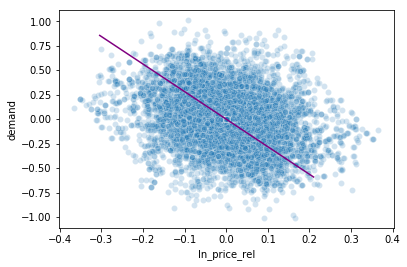

In [109]:
reg_data_df['demand'] = reg_data_df['ln_price_rel']*beta_d_hat
sns.scatterplot(x ='ln_price_rel', y = 'ln_load_rel', alpha = 0.2, data = reg_data_df)
sns.lineplot(x ='ln_price_rel', y = 'demand', color = 'purple', data = reg_data_df.sample(n=100))

In [110]:
-beta_d_hat

2.8131668333823043

### Schwarz et al.

In [1379]:
# Subset dataframe for relevant variables
em_sample_df = data_df.copy()
em_sample_df = df_drop_na(em_sample_df, ['coal_cost'])

# Drop outliers
em_sample_df = drop_outliers(em_sample_df, columns = ['price', 'load'])

In [1380]:
em_sample_df['ln_E_ym']    = np.log(em_sample_df['load'])
em_sample_df['ln_P_ym']    = np.log(em_sample_df['price'])

em_sample_df['ln_E_ym_gm'] = np.mean(em_sample_df['ln_E_ym'])
em_sample_df['ln_P_ym_gm'] = np.mean(em_sample_df['ln_P_ym'])

em_sample_df['E'] = em_sample_df['ln_E_ym'] - em_sample_df['ln_E_ym_gm']
em_sample_df['P'] = em_sample_df['ln_P_ym'] - em_sample_df['ln_P_ym_gm']

em_sample_df['exp_m'] = em_sample_df['price']*em_sample_df['load']
em_sample_df['temp']  = em_sample_df.groupby(['year'])['exp_m'].transform('sum')
em_sample_df['w_ym']  = np.divide(em_sample_df['price']*em_sample_df['load'],
                                 em_sample_df['temp'])
em_sample_df['w_ym_am'] = em_sample_df.groupby(['year'])['w_ym'].transform('mean')
em_sample_df['temp']    = np.multiply(em_sample_df['w_ym'] + em_sample_df['w_ym_am'],
                                      em_sample_df['P'])
em_sample_df['D'] = (1/2)*em_sample_df.groupby(['year'])['temp'].transform('sum')

In [1381]:
smf.ols('E ~ C(state) + np.log(CDD+1) + np.log(HDD+1) + np.add(D, -P) + np.multiply(D, -1)',
       data = em_sample_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      E   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     430.6
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:56:35   Log-Likelihood:                 251.94
No. Observations:                 900   AIC:                            -397.9
Df Residuals:                     847   BIC:                            -143.3
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5582      0.057      9.738      0.000       0.446       0.671
C(state)[T.alaska]            -2.1496      0.099    -21.675      0.000      -2.344      -1.955
C(state)[T.arizona]            0.0252      0.056      0.447      0.655      -0.085       0.136
C(state)[T.arkansas]          -0.6890      0.061    -11.246      0.000      -0.809      -0.569
C(state)[T.california]         1.2491      0.076     16.339      0.000       1.099       1.399
C(state)[T.colorado]          -0.6172      0.057    -10.817      0.000      -0.729      -0.505
C(state)[T.connecticut]       -0.5427      0.089     -6.067      0.000      -0.718      -0.367
C(state)[T.delaware]          -1.7942      0.059    -30.342      0.000      -1.910      -1.678
C(state)[T.florida]            1.1122      0.074     14.984      0.000       0.967       1.258
C(state)[T.georgia]            0.6079      0.055     11.015      0.000       0.500       0.716
C(state)[T.idaho]             -1.5409      0.066    -23.398      0.000      -1.670      -1.412
C(state)[T.illinois]           0.3760      0.056      6.729      0.000       0.266       0.486
C(state)[T.indiana]            0.0546      0.057      0.956      0.339      -0.058       0.167
C(state)[T.iowa]              -0.7413      0.059    -12.625      0.000      -0.857      -0.626
C(state)[T.kansas]            -0.8127      0.056    -14.508      0.000      -0.923      -0.703
C(state)[T.kentucky]          -0.2483      0.063     -3.941      0.000      -0.372      -0.125
C(state)[T.louisiana]         -0.2019      0.069     -2.912      0.004      -0.338      -0.066
C(state)[T.maine]             -1.7748      0.072    -24.611      0.000      -1.916      -1.633
C(state)[T.maryland]          -0.0060      0.062     -0.097      0.923      -0.128       0.116
C(state)[T.massachusetts]     -0.2384      0.081     -2.960      0.003      -0.397      -0.080
C(state)[T.michigan]           0.1892      0.063      3.024      0.003       0.066       0.312
C(state)[T.minnesota]         -0.3372      0.065     -5.223      0.000      -0.464      -0.210
C(state)[T.mississippi]       -0.5757      0.057    -10.093      0.000      -0.688      -0.464
C(state)[T.missouri]           0.0870      0.060      1.462      0.144      -0.030       0.204
C(state)[T.montana]           -2.0218      0.058    -34.860      0.000      -2.136      -1.908
C(state)[T.nebraska]          -1.2754      0.065    -19.720      0.000      -1.402      -1.148
C(state)[T.nevada]            -0.9222      0.064    -14.391      0.000      -1.048      -0.796
C(state)[T.new hampshire]     -1.6273      0.080    -20.344      0.000      -1.784      -1.470
C(state)[T.new jersey]         0.1095      0.068      1.613      0.107      -0.024       0.243
C(state)[T.new mexico]        -1.5464      

In [1382]:
em_sample_df['reg_1'] = np.add(em_sample_df['D'], -em_sample_df['P'])
em_sample_df['reg_2'] = -em_sample_df['D']
em_sample_df['date_fmt'] = em_sample_df.apply(lambda x: str(x.month) + '/' + str(x.year), axis = 1)
em_sample_df.to_csv('../data/processed/ces_monthly_s.csv')

### Nonlinear Control IV

In [180]:
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman

In [181]:
samples = 6817
reg_data_sample_df = reg_data_df.sample(n=samples).copy()
reg_data_sample_df['1'] = 1
print(len(reg_data_sample_df))

6817


#### With all controls

In [182]:
t  = np.array(reg_data_sample_df[['time_diff', 'CDD_1', 'CDD_2', 'HDD_1', 'HDD_2']])
w  = np.array(reg_data_sample_df[['ln_coal_rel']])
p  = np.array(reg_data_sample_df['ln_price_rel'])
q  = np.array(reg_data_sample_df['ln_load_rel'])
tw = np.concatenate((t,w.reshape(-1,1)), axis = 1)

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c'*np.shape(t)[1], 
                              bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='c'*np.shape(t)[1], 
                             bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c'*np.shape(w)[1], 
                             bw=[bw_silverman(w)]).fit(w)

# Estimation of CE(P | T, W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[tw], reg_type='lc', var_type='c'*(np.shape(t)[1]+np.shape(w)[1]), 
                             bw=bw_silverman(tw)).fit(tw)

In [183]:
reg_data_sample_df['ce_q_t']  = ce_q_t
reg_data_sample_df['ce_p_t']  = ce_p_t
reg_data_sample_df['ce_p_w']  = ce_p_w
reg_data_sample_df['ce_p_tw'] = ce_p_tw

In [184]:
fit = smf.ols('np.add(ln_load_rel, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t)', 
              data = reg_data_sample_df
             ).fit(cov_type = 'HC1')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.add(ln_load_rel, -ce_q_t)   R-squared:                       0.094
Model:                                      OLS   Adj. R-squared:                  0.093
Method:                           Least Squares   F-statistic:                     403.4
Date:                          Sat, 04 May 2019   Prob (F-statistic):           3.19e-87
Time:                                  14:15:57   Log-Likelihood:                 6513.7
No. Observations:                          6817   AIC:                        -1.302e+04
Df Residuals:                              6815   BIC:                        -1.301e+04
Df Model:                                     1                                         
Covariance Type:                            HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0001      0.001     -0.126      0.899      -0.002       0.002
np.add(ce_p_tw, -ce_p_t)    -0.8847      0.044    -20.085      0.000      -0.971      -0.798
==============================================================================
Omnibus:                      408.105   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1754.108
Skew:                          -0.077   Prob(JB):                         0.00
Kurtosis:                       5.480   Cond. No.                         29.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [148]:
# Estimation of f(T)
ce_f_t, _ = nparam.KernelReg(endog=[q - p*fit.params[1]], exog=[t], reg_type='lc', var_type='c'*np.shape(t)[1], 
                             bw=bw_silverman(t)).fit(t)

# Stderr on beta
reg_data_sample_df['1'] = 1
reg_data_sample_df['X'] = reg_data_sample_df['ce_p_tw'] - reg_data_sample_df['ce_p_t']
S_xx = np.dot(np.array(reg_data_sample_df[['1', 'X']]).T, np.array(reg_data_sample_df[['1', 'X']]))
beta_std = np.var(fit.predict()-ce_f_t) * (np.linalg.inv(S_xx))
print('stderr:', beta_std[1,1])

stderr: 0.007676714374839933


#### With only degree day controls

In [185]:
t  = np.array(reg_data_sample_df[['CDD_1', 'CDD_2', 'HDD_1', 'HDD_2']])
#t  = np.array(reg_data_sample_df[['time_diff', 'CDD_1', 'CDD_2', 'HDD_1', 'HDD_2']])
w  = np.array(reg_data_sample_df[['ln_coal_rel']])
p  = np.array(reg_data_sample_df['ln_price_rel'])
q  = np.array(reg_data_sample_df['ln_load_rel'])
tw = np.concatenate((t,w.reshape(-1,1)), axis = 1)

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c'*np.shape(t)[1], 
                              bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='c'*np.shape(t)[1], 
                             bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c'*np.shape(w)[1], 
                             bw=[bw_silverman(w)]).fit(w)

# Estimation of CE(P | T, W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[tw], reg_type='lc', var_type='c'*(np.shape(t)[1]+np.shape(w)[1]), 
                             bw=bw_silverman(tw)).fit(tw)

In [186]:
reg_data_sample_df['ce_q_t']  = ce_q_t
reg_data_sample_df['ce_p_t']  = ce_p_t
reg_data_sample_df['ce_p_w']  = ce_p_w
reg_data_sample_df['ce_p_tw'] = ce_p_tw

In [187]:
fit = smf.ols('np.add(ln_load_rel, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t)', 
              data = reg_data_sample_df
             ).fit(cov_type = 'HC1')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.add(ln_load_rel, -ce_q_t)   R-squared:                       0.086
Model:                                      OLS   Adj. R-squared:                  0.085
Method:                           Least Squares   F-statistic:                     548.8
Date:                          Sat, 04 May 2019   Prob (F-statistic):          8.49e-117
Time:                                  14:16:46   Log-Likelihood:                 2917.9
No. Observations:                          6817   AIC:                            -5832.
Df Residuals:                              6815   BIC:                            -5818.
Df Model:                                     1                                         
Covariance Type:                            HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0001      0.002     -0.064      0.949      -0.004       0.004
np.add(ce_p_tw, -ce_p_t)    -1.2123      0.052    -23.427      0.000      -1.314      -1.111
==============================================================================
Omnibus:                       91.609   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.113
Skew:                          -0.071   Prob(JB):                     1.71e-35
Kurtosis:                       3.737   Cond. No.                         25.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [100]:
# Estimation of f(T)
ce_f_t, _ = nparam.KernelReg(endog=[q - p*fit.params[1]], exog=[t], reg_type='lc', var_type='c'*np.shape(t)[1], 
                             bw=bw_silverman(t)).fit(t)

# Stderr on beta
reg_data_sample_df['1'] = 1
reg_data_sample_df['X'] = reg_data_sample_df['ce_p_tw'] - reg_data_sample_df['ce_p_t']
S_xx = np.dot(np.array(reg_data_sample_df[['1', 'X']]).T, np.array(reg_data_sample_df[['1', 'X']]))
beta_std = np.var(fit.predict()-ce_f_t) * (np.linalg.inv(S_xx))
print('stderr:', beta_std[1,1])

stderr: 0.004150069827822194


#### No controls

In [188]:
#t  = np.array(reg_data_sample_df[['CDD_1', 'CDD_2', 'HDD_1', 'HDD_2']])
#t  = np.array(reg_data_sample_df[['time_diff', 'CDD_1', 'CDD_2', 'HDD_1', 'HDD_2']])
w  = np.array(reg_data_sample_df[['ln_coal_rel']])
p  = np.array(reg_data_sample_df['ln_price_rel'])
q  = np.array(reg_data_sample_df['ln_load_rel'])
tw = np.concatenate((t,w.reshape(-1,1)), axis = 1)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c'*np.shape(w)[1], 
                             bw=[bw_silverman(w)]).fit(w)

In [189]:
reg_data_sample_df['ce_p_w']  = ce_p_w

In [190]:
fit = smf.ols('ln_load_rel ~ ce_p_w', 
              data = reg_data_sample_df
             ).fit(cov_type = 'HC1')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     313.8
Date:                Sat, 04 May 2019   Prob (F-statistic):           1.08e-68
Time:                        14:16:50   Log-Likelihood:                -1052.7
No. Observations:                6817   AIC:                             2109.
Df Residuals:                    6815   BIC:                             2123.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0054      0.004     -1.210      0.226      -0.014       0.003
ce_p_w        -2.9976      0.169    -17.716      0.000      -3.329      -2.666
==============================================================================
Omnibus:                        4.783   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                4.977
Skew:                           0.035   Prob(JB):                       0.0831
Kurtosis:                       3.112   Cond. No.                         49.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [109]:
np.sqrt(np.array(fit.cov_params())[1,1])

0.10361278646585403